Trabajo realizado por:

*   Jairo Silvera 
*   Manuel Piñar  
*   Lidia Sanz


INDICE

A. ANALISIS EXPLORATORIO

B. PREPROCESAMIENTO DEL TEXTO

C. RED NEURONAL

D. ANALISIS DE SENTIMIENTOS (pendiente)

CONCLUSIÓN FINAL

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
dir = "/content/drive/MyDrive/Data"

___________________________________________________________________

**A. ANALISIS EXPLORATORIO**

In [3]:
import warnings
warnings.filterwarnings('ignore')

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [4]:
fake = pd.read_csv("/content/drive/MyDrive/Data/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/Data/True.csv")

Noticias falas:



In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
#Noticias falsas por tematicas: 
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#total de registros
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


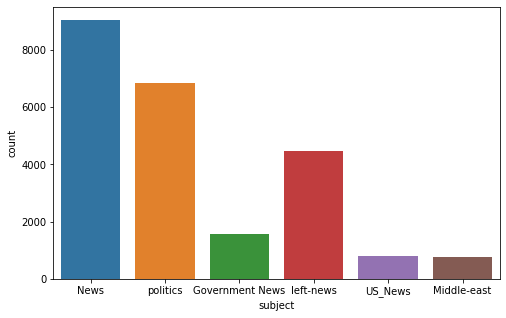

In [7]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

Noticias reales:

In [8]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
#Noticias reales por tematicas: 
for key,count in true.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#total de registros
print(f"Total Records:\t{true.shape[0]}")

politicsNews:	11272
worldnews:	10145
Total Records:	21417


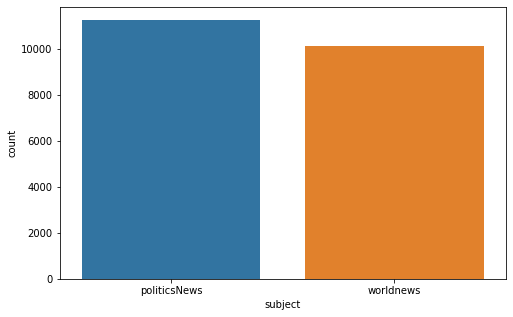

In [10]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=true)
plt.show()

Limpieza de datos del set real:


In [11]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(true.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)


In [12]:
true.iloc[unknown_publishers].text
#verify that data is clean

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [17]:
true.iloc[8970]
# this is empty for some reason so we'll remove it
# sp its not an indicator of real news or fake news

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [18]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(true.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [19]:
#Replace existing text column with new text
#add seperate column for publication info
true["publisher"] = publisher
true["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [20]:
true.head() #nueva columna publisher añadida

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [21]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(true.text.values) if str(text).strip() == '']
#seems only one row 

[8970]

In [22]:
#dropping this record
true = true.drop(8970, axis=0)

In [23]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


___________________________________________________________________

**B. PREPROCESAMIENTO DEL TEXTO**

In [24]:
# Adding class Information
true["class"] = 1
fake["class"] = 0

In [25]:
#Combining Title and Text
true["text"] = true["title"] + " " + true["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [26]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = true.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [27]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)

In [28]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [30]:
!pip install gensim==3.8.3

     |████████████████████████████████| 24.2 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [31]:
import gensim

In [32]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

KeyboardInterrupt: ignored

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122248 words by a 100dim vector.

122248

Explorando vectores

In [ ]:
#see a sample vector for random word, lets say Corona 
w2v_model["corona"]

array([-0.02363007,  0.02366744,  0.0097859 , -0.04335649, -0.03493366,
        0.04463727, -0.07748834, -0.03355906, -0.0231893 , -0.02585695,
        0.05023861,  0.06237992,  0.03567586,  0.02924649, -0.07074341,
       -0.03774568, -0.05462922, -0.03096859,  0.02478338, -0.02002703,
        0.00580078, -0.06944314,  0.01448417, -0.03637731,  0.06823492,
       -0.00039767, -0.00127524,  0.00948866, -0.00714838, -0.02771704,
       -0.02093365,  0.01410918,  0.09504651,  0.07333109,  0.03670519,
        0.05923031,  0.04884078, -0.02656454,  0.05644008,  0.05163852,
       -0.00100978,  0.02280386, -0.02455531,  0.02218635, -0.05160752,
        0.06802923, -0.08897968,  0.003113  , -0.05409062,  0.02386763,
        0.01424762, -0.03717088, -0.00377666, -0.02066629,  0.01032377,
       -0.03812931, -0.04860996,  0.00582938, -0.0497907 , -0.06139951,
        0.06273063,  0.00487955, -0.03714973, -0.03380265,  0.01490968,
        0.05015046,  0.06048831, -0.00614255, -0.01136125,  0.01

In [ ]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.8850116729736328),
 ('iranian', 0.7559810876846313),
 ('hezbollah', 0.6451690196990967),
 ('destabilizing', 0.6330541968345642),
 ('nuclear', 0.6038591861724854),
 ('iranians', 0.5909280776977539),
 ('iaea', 0.5865877270698547),
 ('nuke', 0.5849007368087769),
 ('pyongyang', 0.584214448928833),
 ('jcpoa', 0.5793628692626953)]

In [ ]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7485106587409973),
 ('investigators', 0.6312651634216309),
 ('cia', 0.6248172521591187),
 ('mueller', 0.5951220393180847),
 ('investigation', 0.5732928514480591),
 ('doj', 0.5695614814758301),
 ('dhs', 0.5394120812416077),
 ('probe', 0.5377830862998962),
 ('agents', 0.5338168144226074),
 ('nunes', 0.5331104397773743)]

In [ ]:
w2v_model.wv.most_similar("facebook")

[('reddit', 0.6943188905715942),
 ('instagram', 0.6481629610061646),
 ('fb', 0.643464207649231),
 ('google', 0.6147135496139526),
 ('ciolos', 0.6143431663513184),
 ('gofundme', 0.6068246364593506),
 ('online', 0.599162220954895),
 ('hashtag', 0.5849562883377075),
 ('blog', 0.570426881313324),
 ('4chan', 0.5647458434104919)]

In [ ]:
w2v_model.wv.most_similar("computer")

[('computers', 0.847952127456665),
 ('software', 0.7913548350334167),
 ('laptop', 0.7832947969436646),
 ('malware', 0.765609860420227),
 ('electronic', 0.7575841546058655),
 ('servers', 0.7269469499588013),
 ('scanning', 0.7111114859580994),
 ('encrypted', 0.7020731568336487),
 ('devices', 0.6825416088104248),
 ('kaspersky', 0.6756947636604309)]

In [ ]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('cruz', 0.5389358997344971),
 ('elect', 0.5262603163719177),
 ('bush', 0.5198204517364502),
 ('bartlet', 0.5118899345397949),
 ('course', 0.4955829977989197),
 ('incoming', 0.48780229687690735),
 ('americas_dad', 0.47524431347846985),
 ('hillary', 0.4735332429409027),
 ('crooked', 0.4693392217159271),
 ('actually', 0.46070465445518494)]

No podemos pasar palabras de cadena a la capa de incrustación, por lo que necesitamos alguna forma de representar cada palabra por números.

Tokenizer puede representar cada palabra por número

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [34]:
X[0][:10]

[389, 395, 10495, 54, 5509, 1286, 4840, 315, 205, 16]

In [35]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


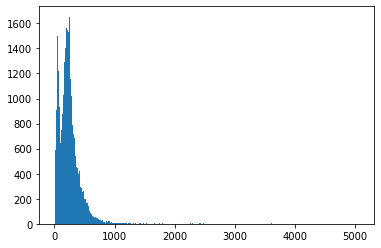

In [36]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [37]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43982

In [38]:
#Lets keep all news to 700
maxlen = 700 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[0])

700

In [40]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

In [41]:
def get_weight_matrix(model, vocab):

    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [42]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

NameError: ignored

___________________________________________________________________

**C. RED NEURONAL**

In [43]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

NameError: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12224900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 532s 719ms/step - loss: 0.1240 - acc: 0.9576 - val_loss: 0.0913 - val_acc: 0.9672
Epoch 2/6
737/737 [==============================] - 526s 714ms/step - loss: 0.0867 - acc: 0.9705 - val_loss: 0.0813 - val_acc: 0.9702
Epoch 3/6
737/737 [==============================] - 527s 715ms/step - loss: 0.0507 - acc: 0.9834 - val_loss: 0.2500 - val_acc: 0.8905
Epoch 4/6
737/737 [==============================] - 531s 721ms/step - loss: 0.0554 - acc: 0.9807 - val_loss: 0.0520 - val_acc: 0.9826
Epoch 5/6
737/737 [==============================] - 531s 721ms/step - loss: 0.0256 - acc: 0.9911 - val_loss: 0.0332 - val_acc: 0.9893
Epoch 6/6
737/737 [==============================] - 536s 727ms/step - loss: 0.0161 - acc: 0.9944 - val_loss: 0.0307 - val_acc: 0.9910


In [ ]:
data.iloc[1].text

'U.S. military to accept transgender recruits on Monday: Pentagon  Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,

In [ ]:
(model.predict(X[0:1]) >= 0.5).astype("int")
# Real news is predicted as real for this example

array([[1]])

In [ ]:
data.iloc[-1].text

'10 U.S. Navy Sailors Held by Iranian Military – Signs of a Neocon Political Stunt 21st Century Wire says As 21WIRE predicted in its new year s look ahead, we have a new  hostage  crisis underway.Today, Iranian military forces report that two small riverine U.S. Navy boats were seized in Iranian waters, and are currently being held on Iran s Farsi Island in the Persian Gulf. A total of 10 U.S. Navy personnel, nine men and one woman, have been detained by Iranian authorities. NAVY STRAYED: U.S. Navy patrol boat in the Persian Gulf (Image Source: USNI)According to the Pentagon, the initial narrative is as follows: The sailors were on a training mission around noon ET when their boat experienced mechanical difficulty and drifted into Iranian-claimed waters and were detained by the Iranian Coast Guard, officials added. The story has since been slightly revised by White House spokesman Josh Earnest to follow this narrative:The 2 boats were traveling en route from Kuwait to Bahrain, when the

In [ ]:
(model.predict(X[-1:]) >= 0.5).astype("int")
# Fake news predicted as fake

array([[0]])

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
len(y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
del model

___________________________________________________________________

**ANALISIS DE SENTIMIENTOS**

In [44]:
true.shape

(21416, 6)

In [45]:
fake.shape

(23481, 2)

In [ ]:
true.head()

In [46]:
# funcion para subjetividad, 0 objetivo, 1 subjetivo
def getSube(twt):
  return TextBlob(twt).sentiment.subjectivity

# funcion para polaridad
def getPol(twt):
  return TextBlob(twt).sentiment.polarity

Adicionar dos nuevas columnas para el dataframe de noticias verdaderas para la subjetividad y polaridad

In [48]:
true['Subjetividad'] = true['text'].apply(getSube) #igual que antes se crea la nueva columna pasando la columna text y se le pasa la funcion indicada con apply()
true['Polaridad'] = true['text'].apply(getPol)
true.head(5)

,title,text,subject,date,publisher,class,Subjetividad,Polaridad
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters),1,0.410250,0.037083
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1,0.292717,0.051296
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1,0.316798,0.115930
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1,0.298053,0.034969
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1,0.396122,0.042165


In [49]:
# funcion para clasificar sentimientos negativos < 0, positivos > 0, neutro = 0 en funcion de la polaridad
def getSenti(value):
  if value < 0:
    return 'Negative'
  elif value > 0:
    return 'Positive'
  else:
    return 'Neutral'

Adicionar nueva columna para el dataframe con el nivel de sentimiento

In [50]:
# crear nueva columna en el dataframe
true['Sentimiento'] = true['Polaridad'].apply(getSenti) #
true.head(15)

,title,text,subject,date,publisher,class,Subjetividad,Polaridad,Sentimiento
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters),1,0.410250,0.037083,Positive
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1,0.292717,0.051296,Positive
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1,0.316798,0.115930,Positive
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1,0.298053,0.034969,Positive
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1,0.396122,0.042165,Positive
5,"White House, Congress prepare for talks on spe...","White House, Congress prepare for talks on spe...",politicsNews,"December 29, 2017","WEST PALM BEACH, Fla./WASHINGTON (Reuters)",1,0.345550,-0.017026,Negative
6,"Trump says Russia probe will be fair, but time...","Trump says Russia probe will be fair, but time...",politicsNews,"December 29, 2017","WEST PALM BEACH, Fla (Reuters)",1,0.482101,-0.000253,Negative
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,Factbox: Trump on Twitter (Dec 29) - Approval ...,politicsNews,"December 29, 2017",The following statements were posted to the ve...,1,0.592500,-0.108750,Negative
8,Trump on Twitter (Dec 28) - Global Warming,Trump on Twitter (Dec 28) - Global Warming To...,politicsNews,"December 29, 2017",The following statements were posted to the ve...,1,0.431061,0.119665,Positive
9,Alabama official to certify Senator-elect Jone...,Alabama official to certify Senator-elect Jone...,politicsNews,"December 28, 2017",WASHINGTON (Reuters),1,0.533333,-0.066667,Negative


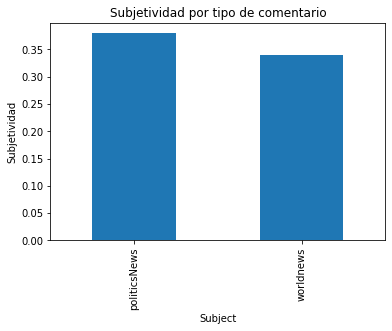

In [51]:
true.groupby(['subject'])['Subjetividad'].mean('Subjetividad').plot(kind='bar')
plt.title('Subjetividad por tipo de comentario')
plt.xlabel('Subject')
plt.ylabel('Subjetividad')
plt.show()

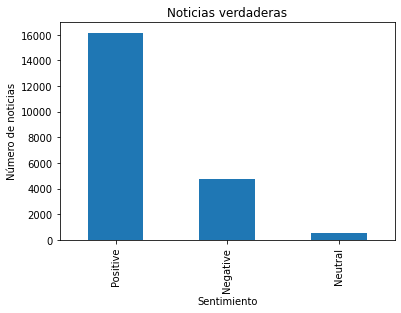

In [52]:
# barchart 
true['Sentimiento'].value_counts().plot(kind='bar')
plt.title('Noticias verdaderas')
plt.xlabel('Sentimiento')
plt.ylabel('Número de noticias')
plt.show()

Adicionar dos nuevas columnas para el dataframe de noticias fake para la subjetividad y polaridad

In [53]:
fake['Subjetividad'] = fake['text'].apply(getSube) #se crea la nueva columna pasando la columna text y se le pasa la funcion indicada con apply()
fake['Polaridad'] = fake['text'].apply(getPol)
fake.head(5)

,text,class,Subjetividad,Polaridad
0,Donald Trump Sends Out Embarrassing New Year’...,0,0.600891,0.072534
1,Drunk Bragging Trump Staffer Started Russian ...,0,0.344802,-0.020811
2,Sheriff David Clarke Becomes An Internet Joke...,0,0.541969,-0.012345
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,0.413021,-0.038021
4,Pope Francis Just Called Out Donald Trump Dur...,0,0.495222,-0.011722


Adicionar nueva columna para el dataframe con el nivel de sentimiento

In [54]:
# crear nueva columna en el dataframe
fake['Sentimiento'] = fake['Polaridad'].apply(getSenti) #
fake.head()

,text,class,Subjetividad,Polaridad,Sentimiento
0,Donald Trump Sends Out Embarrassing New Year’...,0,0.600891,0.072534,Positive
1,Drunk Bragging Trump Staffer Started Russian ...,0,0.344802,-0.020811,Negative
2,Sheriff David Clarke Becomes An Internet Joke...,0,0.541969,-0.012345,Negative
3,Trump Is So Obsessed He Even Has Obama’s Name...,0,0.413021,-0.038021,Negative
4,Pope Francis Just Called Out Donald Trump Dur...,0,0.495222,-0.011722,Negative


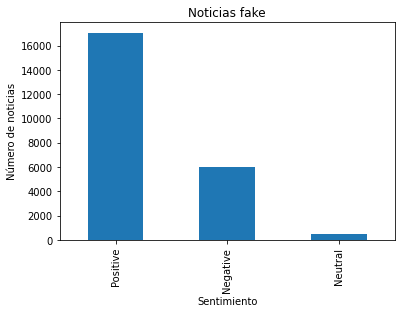

In [55]:
# barchart 
fake['Sentimiento'].value_counts().plot(kind='bar')
plt.title('Noticias fake')
plt.xlabel('Sentimiento')
plt.ylabel('Número de noticias')
plt.show()

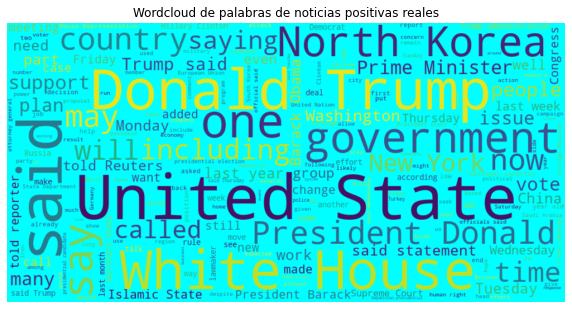

In [56]:
positive_words =' '.join([text for text in true['text'][true['Sentimiento'] == 'Positive']])

wordcloud = WordCloud(background_color = 'cyan', width=1000, height=500, random_state = 0, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud de palabras de noticias positivas reales')
plt.show()

In [ ]:
negative_words =' '.join([text for text in fake['text'][fake['Sentimiento'] == 'Negative']])

wordcloud = WordCloud(background_color = 'cyan', width=1000, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud de palabras de noticias negativas fake')
plt.show()

#Conclusiones:

1.   Primero se ha querido elaborar una red neuronal capaz de diferenciar cuando una noticia es real o verdadera en función del dataset descargado desde Kaggle donde se reúne un gran numero de noticias con el enfoque político que tengan y si son fake o reales.
2.   Se ha planteado un modelo en red neuronal LSTM con un total de parametros de 12,342,277 con el cual hemos conseguido un accuracy del 99.1% en el conjunto de test.
3.   El siguiente paso se ha utlizado la libreria TextBlob la cual realiza un análisis de sentimiento sobre cada noticia, donde TExtBlob asigna un valor de polaridad y subjetividad
4.   Con el análisis de sentimiento se asigna el respectivo puntaje para determinar si el sentimiento es positivo, negativo o neutral, para ello disponemos de dos datasets uno con noticias reales y el otro fake.







